# Variational inference in the IBP using the finite approximation

trying stochastic gradient

In [41]:
#import numpy as np
#import scipy as sp
from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np
import autograd.scipy as sp


import matplotlib.pyplot as plt
from copy import deepcopy

from valez_finite_VI_lib import *


# Define stochastic gradient

In [138]:
def unravel_pars(pars, D, K, N): 
    # takes the concantenated list of phi_mu, phi_var, tau, nu, and returns the original arrays
    
    assert len(pars) == (D*K + K + 2*K + N*K)
    
    phi_mu = np.reshape(pars[0:D*K], (D, K))
    phi_var = pars[D*K:D*K+K]
    tau = np.reshape(pars[D*K+K:D*K+3*K], (K,2) )
    nu = np.reshape(pars[D*K+3*K:], (N,K))
    
    return(phi_mu, phi_var, tau, nu)


def SGD_elbo(pars, X_approx, sigmas, alpha, K, N_obs): 
    # this function takes the concantenated form of phi_mu, phi_var, tau, nu_approx and passes it to compute_elbo
    # note it takes the subsampled version of X and nu
    # moreover, it incorporates the normalizing constant needed for SGD
    
    N_approx = np.shape(X_approx)[0]
    D = np.shape(X_approx)[1]
    
    [phi_mu, phi_var, tau, nu_approx] = unravel_pars(pars, D, K, N_approx)

    assert np.shape(X_approx)[0] == np.shape(nu_approx)[0]
    assert np.shape(X_approx)[1] == np.shape(phi_mu)[0]
    assert np.shape(nu_approx)[1] == np.shape(phi_mu)[1]
    assert np.shape(tau)[0] == np.shape(nu_approx)[1]

    #[tmp, elbo_term1, elbo_term2, elbo_term3, elbo_term4, elbo_term5, elbo_term6, elbo_term7] \
    #    = compute_elbo(tau, nu_approx, phi_mu, phi_var, X_approx, sigmas, alpha)
    
    
    elbo_term1 = compute_elbo(tau, nu_approx, phi_mu, phi_var, X_approx, sigmas, alpha)[1]
    elbo_term2 = compute_elbo(tau, nu_approx, phi_mu, phi_var, X_approx, sigmas, alpha)[2]
    elbo_term3 = compute_elbo(tau, nu_approx, phi_mu, phi_var, X_approx, sigmas, alpha)[3]
    elbo_term4 = compute_elbo(tau, nu_approx, phi_mu, phi_var, X_approx, sigmas, alpha)[4]
    elbo_term5 = compute_elbo(tau, nu_approx, phi_mu, phi_var, X_approx, sigmas, alpha)[5]
    elbo_term6 = compute_elbo(tau, nu_approx, phi_mu, phi_var, X_approx, sigmas, alpha)[6]
    elbo_term7 = compute_elbo(tau, nu_approx, phi_mu, phi_var, X_approx, sigmas, alpha)[7]
    
    # rescale terms 2, 4, and 7
    SGD_constant = N_obs/N_approx
    
    elbo = elbo_term1 + SGD_constant * elbo_term2 + elbo_term3 + SGD_constant * elbo_term4 \
        + elbo_term5 + elbo_term6 + SGD_constant * elbo_term7
        
    return(elbo)

def stoch_grad(tau, nu, phi_mu, phi_var, X, sigmas, alpha, N_approx, max_iter=1000): 
    N_obs = np.shape(X)[0]
    K = np.shape(nu)[1]
    D = np.shape(X)[1]
    
    pars_all = np.concatenate((phi_mu.flatten(), \
       phi_var, \
       tau.flatten(), \
       nu.flatten())) 
    
    elbo = []
    
    stepsize = .05
    
    for i in range(max_iter):
        
        nu_copy = deepcopy(nu)
        phi_mu_copy = deepcopy(phi_mu)
        tau_copy = deepcopy(tau)
        
        # subsample data
        #index = np.random.choice(N_obs, N_approx, replace = False)
        index = np.arange(N_obs)
        X_approx = X[index, :]
        nu_approx = nu[index, :]
                
        assert np.shape(X_approx)[0] == np.shape(nu_approx)[0]
        assert np.shape(X_approx)[1] == np.shape(phi_mu)[0]
        assert np.shape(nu_approx)[1] == np.shape(phi_mu)[1]

        pars_approx = np.concatenate((phi_mu.flatten(), \
                               phi_var, \
                               tau.flatten(), \
                               nu_approx.flatten())) # 
        
        # compute (stochastic) gradient -- note we are using nu_approx and X_approx
        d_elbo = grad(SGD_elbo,0)
        
        #print(pars_approx)
        #print(d_elbo(pars_approx, X_approx, sigmas, alpha, K, N_obs))
        
        # update parameters                            
        pars_approx += stepsize * d_elbo(pars_approx, X_approx, sigmas, alpha, K, N_obs)
        
        
        [phi_mu, phi_var, tau, nu_approx] = unravel_pars(pars_approx, D,K,N_approx)
        
        
        tau[tau<0] = 0
        nu_approx[nu_approx>1] = 1
        nu_approx[nu_approx<0] = 0
    
        nu[index, :] = nu_approx
        
        elbo.append(compute_elbo(tau, nu, phi_mu, phi_var, X, sigmas, alpha)[0])
        print('iteration: ', i, 'elbo: ', elbo[i])
        print(np.abs(np.sum(nu[:] - nu_copy[:])))
        print(np.abs(np.sum(phi_mu[:] - phi_mu_copy[:])))
        print(np.abs(np.sum(tau[:] - tau_copy[:])))
        
        #if ((i>0) and np.abs(elbo[i]-elbo[i-1]) <= 10**(-8)):
        #    print('elbo converged')
            

        
    return(phi_mu, phi_var, tau, nu, elbo)
    

In [139]:
'''
N = np.shape(X)[0]
K = np.shape(nu)[1]
D = np.shape(X)[1]
print(D,K,N)
print(phi_mu)
print(phi_var)
print(tau)

pars = np.concatenate((phi_mu.flatten(), \
                       phi_var.flatten(), \
                       tau.flatten(), \
                       nu.flatten()))
#print(pars)
phi_mu_test = np.reshape(pars[0:D*K], (D, K))
phi_var_test = pars[D*K : D*K+K]
tau_test = np.reshape(pars[D*K+K:D*K+3*K], (K,2) )
nu = np.reshape(pars[D*K+3*K:], (N,K))
print('\n')
print(phi_mu_test)
print(phi_var_test)
print(tau_test)

assert np.shape(X)[0] == np.shape(nu)[0]
assert np.shape(X)[1] == np.shape(phi_mu)[0]
assert np.shape(nu)[1] == np.shape(phi_mu)[1]
assert np.shape(tau)[0] == np.shape(nu)[1]

'''
a = []
a.append(2)
print(a)

[2]


# Draw data

In [140]:
#np.random.seed(43141) 
np.random.seed(4132) 

N_obs = 4 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP


alpha = 10 # IBP parameter
Pi = np.ones(K_inf) * .8
Z = np.zeros([N_obs,K_inf])

# Parameters to draw A from MVN
mu = np.zeros(D)
sigma_A = 100

sigma_eps = .1 # variance of noise

# Draw Z from truncated stick breaking process
for k in range(K_inf):
    # Pi[k] = np.random.beta(alpha/K_inf,1)
    for n in range(N_obs):
        Z[n,k] = np.random.binomial(1,Pi[k])

        
print('true Z (first 10 rows): \n', Z[0:10,:])

# Draw A from multivariate normal
# A = np.random.multivariate_normal(mu, sigma_A*np.identity(D), K_inf) # FOR SOME REASONG THIS KILLS THE KERNEL!?
A = np.random.normal(0, np.sqrt(sigma_A), (K_inf, D))
print(A)

# draw noise
# epsilon = np.random.multivariate_normal(np.zeros(D), sigma_eps*np.identity(D), N_obs)
epsilon = np.random.normal(0, sigma_eps, (N_obs, D))

# the observed data
X = np.dot(Z,A) + epsilon


true Z (first 10 rows): 
 [[ 1.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  1.  1.]
 [ 1.  1.  0.]]
[[ -2.95836644  -8.38365709]
 [  9.56099935  -5.36382728]
 [  3.6818894   21.55513128]]


# set initializations

In [141]:
K_approx = deepcopy(K_inf) # variational truncation

tau = np.random.uniform(0,1,[K_approx,2]) # tau1, tau2 -- beta parameters for v
#tau = np.ones([K_approx,2])*1000
#tau[:,1] = (tau[:,0] - Pi*tau[:,0])/Pi

#nu = np.ones([N_obs, K_approx]) *0.0
nu =  np.random.uniform(0,1,[N_obs,K_approx]) # Bernoulli parameter for z_nk
#nu = deepcopy(Z)

phi_mu = np.random.normal(0,1,[D,K_approx]) # kth mean (D dim vector) in kth column
#phi_mu = deepcopy(A).T
phi_var = np.ones(K_approx)

nu_init = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

iterations = 1000

sigmas = {'eps': sigma_eps, 'A': sigma_A}


# run SGD

In [142]:
np.array([i for i in range(5)])
print(0**0)

1


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/core.py:69: RuntimeWarning: invalid value encountered in log
  result_value = self.fun(*argvals, **kwargs)
/home/runjing_liu/Documents/BNP/Variational_BNP_robustness/Finite_approx/valez_finite_VI_lib.py:145: RuntimeWarning: invalid value encountered in double_scalars
  digamma_tau[k,1] - digamma_sum_tau[k]
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/core.py:69: RuntimeWarning: invalid value encountered in multiply
  result_value = self.fun(*argvals, **kwargs)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/scipy/special.py:20: RuntimeWarning: invalid value encountered in multiply
  digamma.defvjp(  lambda g, ans, vs, gvs, x: g * polygamma(1, x))
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/core.py:199: RuntimeWarning: invalid value encountered in add
  x += y
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid v

iteration:  0 elbo:  nan
0.440323421853
21.2538146843
237.974288985
iteration:  1 elbo:  nan
3.89544561152
21.4358848712
nan
iteration:  2 elbo:  nan

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:91: RuntimeWarning: invalid value encountered in greater
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:92: RuntimeWarning: invalid value encountered in less



nan
29.2459403121
nan
iteration:  3 elbo:  nan
nan
nan
nan
iteration:  4 elbo:  nan
nan
nan
nan
iteration:  5 elbo:  nan
nan
nan
nan
iteration:  6 elbo:  nan
nan
nan
nan
iteration:  7 elbo:  nan
nan
nan
nan
iteration:  8 elbo:  nan
nan
nan
nan
iteration:  9 elbo:  nan
nan
nan
nan


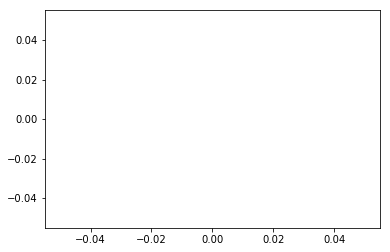

[[ nan  nan  nan]
 [ nan  nan  nan]
 [ nan  nan  nan]
 [ nan  nan  nan]]


In [143]:
N_approx = N_obs
# print(N_approx)
[phi_mu, phi_var, tau, nu, elbo] = stoch_grad(tau, nu, phi_mu, phi_var, X, sigmas, alpha, N_approx, 10)

plt.plot(elbo)
plt.show()

print(nu)


# Look at results 

In [137]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)
print('Z (unpermuted): \n', Z[0:10])

# Find the minimizing permutation.
accuracy_mat = [[ np.sum(np.abs(Z[:, i] - nu[:, j]))/N_obs for i in range(K_inf) ]
                  for j in range(K_inf) ]
perm_tmp = np.argmin(accuracy_mat, 1)

if len(perm_tmp) == len(set(perm_tmp)):  # check that we have a true permuation
    perm = np.argmin(accuracy_mat, 1)
else: 
    print('** procedure did not give a true permutation')
    perm = [0,1,2]
perm = [2,1,0]
print('permutation: ', perm)
    
# print Z (permuted) and nu
print('Z (permuted) \n', Z[0:10, perm])
print('round_nu \n', round_nu[0:10,:])

print('l1 error (after permutation): ', \
      [ np.sum(np.abs(Z[:, perm[i]] - nu[:, i]))/N_obs for i in range(K_inf) ])

print('\n')
print('true A (permuted): \n', A[perm, :])
print('phi_mu: \n', phi_mu.transpose())

print('\n')
print('true Pi (permuted): ', Pi)
print('computed Pi: ', Pi_computed)
plt.clf()
plt.plot(elbo[:iter_ran])
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

Z (unpermuted): 
 [[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  0.]]
** procedure did not give a true permutation
permutation:  [2, 1, 0]
Z (permuted) 
 [[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 0.  1.  1.]]
round_nu 
 [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
l1 error (after permutation):  [0.75, 1.0, 1.0]


true A (permuted): 
 [[ -7.05981612 -13.02391429]
 [-11.43550446  -5.73532868]
 [-10.9940743   15.96990485]]
phi_mu: 
 [[ 39.05973757  -0.87072419]
 [ 49.49153633  -0.25928286]
 [ 48.83415837   4.1999165 ]]


true Pi (permuted):  [ 0.8  0.8  0.8]
computed Pi:  [ 0.49133875  0.491841    0.49199769]


NameError: name 'iter_ran' is not defined

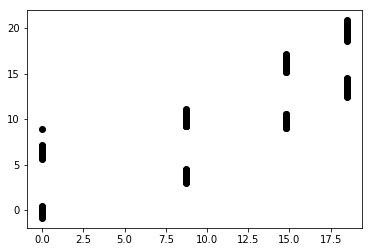

In [112]:
pred_x = np.dot(nu, phi_mu.transpose())
col = 1
plt.clf()
plt.plot(pred_x[:, col], X[:, col], 'ko')
plt.show()